In [4]:
source('packages.r')
load('/g/scb2/zeller/karcher/dysb_classif/data/siamcat/profiles_merged_with_metadata.rimage')

In [6]:
# load their assoc file
gupta_assocs <- read_tsv("../data//gupta_et_al/gupta_assocs.tab")
guptaTaxaInMOTUS <- dataMetaAdaptedTruncWideAll %>%
as.data.frame() %>%
mutate(taxon = rownames(.)) %>%
# some mOTU clusters are of the form
#Bifidobacterium catenulatum/kashiwanohense	
# To make this findable in an ad-hoc manner, do this      
mutate(taxon = map_chr(taxon, function(x) {
    if (str_detect(x, "/")) {
        genus <- str_split(x, " ")[[1]][1]
        species_ids <- str_split(x, "/")[[1]]
        species_ids <- map2_chr(species_ids, 1:length(species_ids), function(x, i) {
            if (i == 1) {
                return(str_split(x, " ")[[1]][2])
            } else {
                return(str_split(x, " ")[[1]][1])
            }
        })
        return(str_c(genus, species_ids, sep = " ", collapse = '/'))
    } else {
        return(x)
    }
})) %>% filter(map_lgl(taxon, function(x) {
    hits <- map_lgl(gupta_assocs$`Species name`, function(y) {
        str_detect(string = x, pattern = y) %>%
        return()
    })
    any(hits) %>% return()
})) %>% 
pivot_longer(-taxon)

Parsed with column specification:
cols(
  Group = col_character(),
  `Species name` = col_character(),
  `Prevalence in healthy samples, PH (%)` = col_double(),
  `Prevalence in nonhealthy samples, PN (%)` = col_double(),
  `Difference, PH − PN (%)` = col_character(),
  `Fold change, PH/PN or PN/PH` = col_double()
)



In [7]:
print(str_c("We can find a total of ", guptaTaxaInMOTUS %>% pull(taxon) %>% unique() %>% length(), 
            " mOTU clusters in mOTUs. There are a total of 50 taxa reported as part of the GMHI."))

[1] "We can find a total of 45 mOTU clusters in mOTUs. There are a total of 50 taxa reported as part of the GMHI."


In [8]:
gupta_assocs <- gupta_assocs %>%
rename(prevControls = `Prevalence in healthy samples, PH (%)`,
      prevCases = `Prevalence in nonhealthy samples, PN (%)`,
      prevDifference = `Difference, PH − PN (%)`,
      prevFC = `Fold change, PH/PN or PN/PH`) %>%
mutate(prevDifference = map_chr(prevDifference, function(x) str_replace(x, "–", "-"))) %>%
mutate(prevDifference = map_chr(prevDifference, function(x) str_replace(x, "−", "-"))) %>%
mutate(prevDifference = as.numeric(prevDifference)) %>%
mutate(prevFC = as.numeric(prevFC))

In [9]:
guptaTaxaInMOTUS <- guptaTaxaInMOTUS %>%
rename(Sample_ID = name,
      relativeAbundance = value) %>%
mutate(taxon = map_chr(taxon, function(x) str_split(x, " \\[")[[1]][1])) %>%
mutate(taxon = ifelse(taxon == "Fusobacterium nucleatum subsp. animalis", "Fusobacterium nucleatum", taxon)) %>%
mutate(taxon = ifelse(taxon == "Fusobacterium nucleatum subsp. vincentii", "Fusobacterium nucleatum", taxon)) %>%                         
# some mOTU clusters encompass the same species
# group, sum up rel. abundances
group_by(Sample_ID, taxon) %>%
summarize(relativeAbundance = sum(relativeAbundance)) %>%                       
ungroup() %>%
group_by(taxon) %>%                       
left_join(metaDataWGS %>%
          mutate(Sample_ID = rownames(.)), by = 'Sample_ID') %>%
nest() %>%
mutate(prevControls = map_dbl(data, function(x) x %>% filter(caseControls == "control") %>% pull(relativeAbundance) %>% {mean(. > 1E-5)})) %>%
mutate(prevCases = map_dbl(data, function(x) x %>% filter(caseControls == "case") %>% pull(relativeAbundance) %>% {mean(. > 1E-5)})) %>%
mutate(prevDifference = prevControls - prevCases) %>%
mutate(prevFC = prevControls/prevCases) %>%
select(-data) %>%
rename(`Species name` = taxon) %>%
# Split mOTU clusters with more than one mapped species for easier mapping                       
  group_by(`Species name`) %>%
  nest() %>%
  mutate(data = map2(data, `Species name`, function(x, s) {
    
    if (!str_detect(s, "/")[[1]]) {
      #tmp <- str_split(s, "/")[[1]]
      out <- tibble(tmp = s, 
                    prevCases = x$prevCases,
                    prevDifference = x$prevDifference,
                    prevControls = x$prevControls,
                    prevFC = x$prevFC) %>%
      rename(`Species name` = tmp)
    } else {
      tmp <- str_split(s, "/")[[1]]
      out <- tibble(tmp = tmp, 
                    prevCases = x$prevCases,
                    prevControls = x$prevControls,
                    prevDifference = x$prevDifference,
                    prevFC = x$prevFC) %>%
      rename(`Species name` = tmp)
      return(out)
    }
  })) %>%
select(-`Species name`) %>%
unnest() %>%
mutate(`Species name` = `Species name1`) %>%
select(-`Species name1`)


`summarise()` regrouping output by 'Sample_ID' (override with `.groups` argument)
Adding missing grouping variables: `Species name`
Warning message:
“`cols` is now required when using unnest().
Please use `cols = c(data)`”


In [10]:
guptaTaxaInMOTUS <- guptaTaxaInMOTUS %>%
left_join(gupta_assocs, by = 'Species name', suffix = c(".ours", ".gupta")) %>%
rename(direction = Group) %>%
mutate(higherInControls.gupta = ifelse(direction == "H+", TRUE,  FALSE)) %>%
select(-direction) %>%
mutate(higherInControls.ours = prevControls.ours > prevCases.ours) %>%
relocate(`Species name`, prevControls.ours, prevControls.gupta,
         prevCases.ours, prevCases.gupta,
         prevDifference.ours, prevDifference.gupta,
         prevFC.ours, prevFC.gupta,
         higherInControls.ours, higherInControls.gupta) %>%
                       mutate(prevControls.ours = prevControls.ours * 100,
                             prevCases.ours = prevCases.ours * 100,
                             prevDifference.ours = prevDifference.ours * 100) %>%
filter(!is.na(prevControls.gupta))


guptaTaxaInMOTUS <- guptaTaxaInMOTUS[abs(guptaTaxaInMOTUS$prevControls.ours - 3.35839598997494) > 1E-8, ]

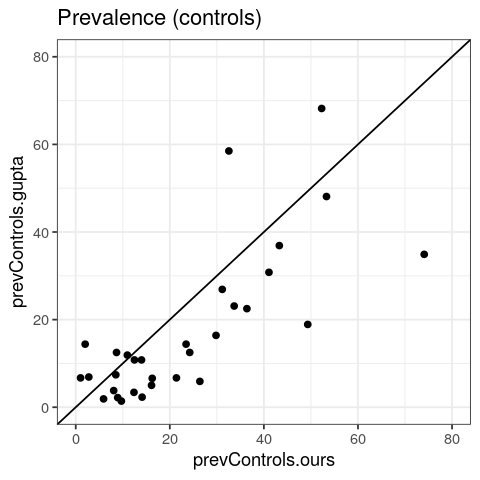

In [11]:
options(repr.plot.width=4, repr.plot.height=4)
ggplot(guptaTaxaInMOTUS, aes(x = prevControls.ours, y = prevControls.gupta)) +
geom_point() +
theme_bw() +
ggtitle("Prevalence (controls)") +
xlim(c(0, 80)) +
ylim(c(0, 80)) +
geom_abline(intercept = 0, slope = 1)

Warning message:
“Removed 1 rows containing missing values (geom_point).”


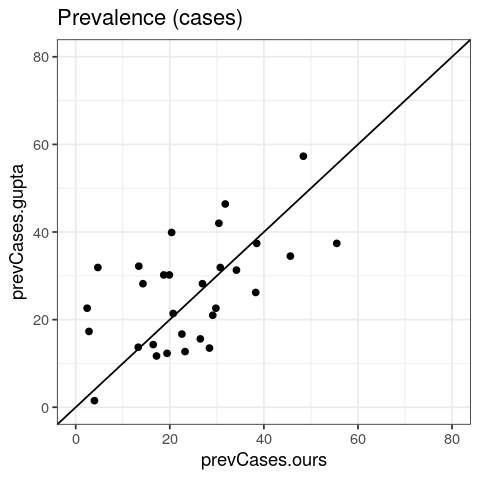

In [12]:
options(repr.plot.width=4, repr.plot.height=4)
ggplot(guptaTaxaInMOTUS, aes(x = prevCases.ours, y = prevCases.gupta)) +
geom_point() +
theme_bw() +
ggtitle("Prevalence (cases)") +
xlim(c(0, 80)) +
ylim(c(0, 80)) +
geom_abline(intercept = 0, slope = 1)

options(repr.plot.width=4, repr.plot.height=4)

p1 <- ggplot(guptaTaxaInMOTUS, aes(x = prevDifference.ours, y = prevDifference.gupta)) +
geom_point() +
theme_bw() +
ggtitle("Prevalence differences") +
xlim(c(-30, 30)) +
ylim(c(-30, 30)) +
geom_abline(intercept = 0, slope = 1)

print(p1)

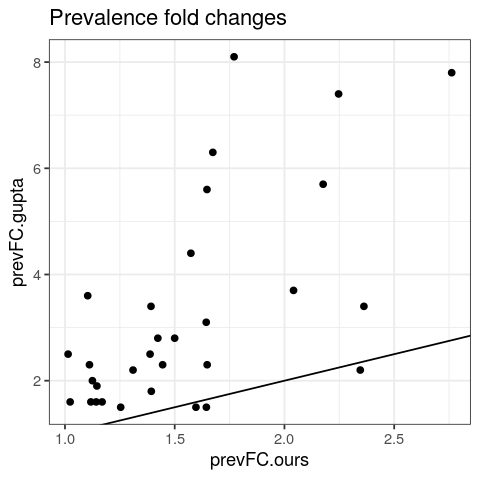

In [13]:
options(repr.plot.width=4, repr.plot.height=4)

p1 <- ggplot(guptaTaxaInMOTUS %>%
             mutate(prevFC.ours = ifelse(prevFC.ours < 1, 1/prevFC.ours, prevFC.ours)), aes(x = prevFC.ours, y = prevFC.gupta)) +
geom_point() +
theme_bw() +
ggtitle("Prevalence fold changes") +
#xlim(c(-30, 30)) +
#ylim(c(-30, 30)) +
geom_abline(intercept = 0, slope = 1)

print(p1)

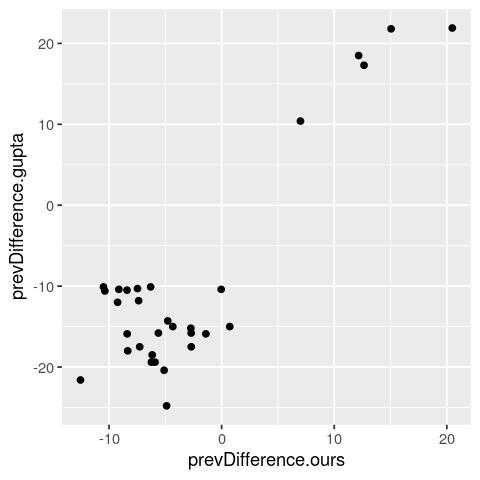

In [14]:
ggplot(guptaTaxaInMOTUS, aes(x = prevDifference.ours, y = prevDifference.gupta)) + geom_point()